#**유통 판매량 예측 및 재고 최적화**

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/project6/취합/'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

In [ ]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')
weather = pd.read_csv(path + 'train/weather_train.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'])
weather['Date'] = pd.to_datetime(weather['Date'])

# **2.데이터셋 구성하기**



In [ ]:
order_44 = orders[orders.Store_ID == 44]

## **(1) 상품 : 3 - Beverage**

In [ ]:
data_3 = sales[(sales.Store_ID == 44) & (sales.Product_ID == 3)]

# 3번 상품의 경우 크리스마스에 대한 데이터가 없어 추가하는 작업 필요
df25 = pd.DataFrame({'Date' : ['2014-12-25', '2015-12-25', '2016-12-25'], 'Store_ID' : [44, 44, 44], 'Qty' : [0, 0, 0], 'Product_ID': [3, 3, 3]})
# tmp = sales3.append(df25, ignore_index = True)

data_3 = pd.concat([data_3, df25], ignore_index = True)
data_3['Date'] = pd.to_datetime(data_3['Date'])
data_3.sort_values(by='Date', inplace=True)

In [ ]:
data_3 = pd.merge(data_3, order_44, how='left', on=['Date', 'Store_ID'])
data_3 = pd.merge(data_3, oil_price, how='left', on=['Date'])
data_3 = pd.merge(data_3, weather, how='left', on=['Date'])

data_3['Year'] = data_3['Date'].dt.year
data_3['Weekday'] = data_3['Date'].dt.weekday
data_3['Month'] = data_3['Date'].dt.month

# 공휴일 캘린더 설정 (미국 연방 공휴일 기준)
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays()

data_3['Holiday'] = np.where((data_3['Weekday'] >= 5) | (data_3['Date'].isin(holidays)), 1, 0)

### **1)결측치 처리**

In [ ]:
data_3[data_3.Qty<=1]

special_day = [358, 365, 723, 730, 732, 733, 1089, 1096]

def fill_CustomerCount(i):
    data_3.CustomerCount.iloc[i] = (data_3.CustomerCount.iloc[i-1] + data_3.CustomerCount.iloc[i-2] + data_3.CustomerCount.iloc[i-3] + data_3.CustomerCount.iloc[i-4]) // 4
def fill_Qty(i):
    data_3.Qty.iloc[i] = (data_3.Qty.iloc[i-1] + data_3.Qty.iloc[i-2] + data_3.Qty.iloc[i-3] + data_3.Qty.iloc[i-4]) // 4

for idx in special_day:
  fill_CustomerCount(idx)
  if idx not in [732, 733]:
    fill_Qty(idx)

data_3.Qty.iloc[0] = data_3.Qty.iloc[1]
data_3.CustomerCount.iloc[0] = data_3.CustomerCount.iloc[1]

### **2)피처 엔지니어링**

In [ ]:
# 나쁜 날씨 추가
data_3['snowrain'] = data_3['Precipitation (inches)'] + data_3['Snow (inches)']
data_3.drop(columns=['Store_ID', 'Product_ID', 'Precipitation (inches)', 'Snow (inches)'], inplace=True)


# 통계 데이터 추가
Qty_stats = data_3.groupby(by=['Year', 'Month'], as_index=False)['Qty'].agg(['mean', 'std'])
CustomerCount_stats = data_3.groupby(by=['Year', 'Month'], as_index=False)['CustomerCount'].agg(['mean', 'std'])

data_3 = pd.merge(data_3, Qty_stats, how='left', on=['Year', 'Month'])
data_3 = pd.merge(data_3, CustomerCount_stats, how='left', on=['Year', 'Month'])
data_3.drop([1153,1154], axis=0, inplace=True)

# column명 변경
data_3.rename(columns={"Maximum Temperature degrees (F)": "Max_Temp", "Minimum Temperature degrees (F)": "Min_Temp"}, inplace=True)
data_3.rename(columns={"mean_x": "Qty_mean", "std_x": "Qty_std", "mean_y": "Customer_mean", "std_y": "CustomerCount_std"}, inplace=True)
data_3.rename(columns={"Snow Depth (inches)": "Snow_Depth"}, inplace=True)
data_3.drop(columns='Date', inplace=True)

# 타겟 데이터 추가
data_3['y'] = data_3['Qty'].shift(-2)

In [ ]:
data_3.head()

,Qty,CustomerCount,WTI_Price,Max_Temp,Min_Temp,Snow_Depth,year,weekday,month,holiday,snowrain,Qty_mean,Qty_std,Customer_mean,CustomerCount_std,y
0,9853.0,4422.0,NaN,1.0,-8.0,6.0,2014,2,1,1,0.00,8840.935484,3030.593121,4155.193548,525.890446,8647.0
1,9853.0,4422.0,95.14,4.0,-10.0,6.0,2014,3,1,0,0.00,8840.935484,3030.593121,4155.193548,525.890446,15153.0
2,8647.0,4167.0,93.66,29.0,-10.0,6.0,2014,4,1,0,0.42,8840.935484,3030.593121,4155.193548,525.890446,15606.0
3,15153.0,5341.0,NaN,35.0,-2.0,6.0,2014,5,1,1,0.02,8840.935484,3030.593121,4155.193548,525.890446,7900.0
4,15606.0,5123.0,NaN,-2.0,-20.0,6.0,2014,6,1,1,0.00,8840.935484,3030.593121,4155.193548,525.890446,7188.0


## **(2) 상품 : 12 - Milk**

In [ ]:
data_44 = sales[(sales.Store_ID == 44)]

# 12번 상품과 correlation이 높은 상품 추
"""
Product_ID
7     0.812159
8     0.811386
5     0.771599
3     0.770926
10    0.722277
Name: 12, dtype: float64

Cleaning
Yogurt
BAKERY
Beverage
EGGS
1.1, 12.25
"""
maxcor_idx = [12, 7, 8, 5, 3, 10]

# Product_ID가 12이거나 maxcor_idx에 포함된 값들만 필터링
filtered_sales = data_44[data_44['Product_ID'].isin(maxcor_idx)]

# 피벗 테이블 생성: Product_ID를 인덱스로, Date를 열로, Qty를 값으로
pivot_table = filtered_sales.pivot_table(index='Date', columns='Product_ID', values='Qty', fill_value=0)

orders_44 = orders.loc[orders['Store_ID'].isin([44])]
data_12 = pd.merge(pivot_table, orders_44, on='Date', how='left') #left

data_12 = pd.merge(data_12, weather, on='Date', how='left')

# '12' 값을 이틀 뒤로 이동
data_12['12_shifted'] = data_12[12].shift(-2)

# 불필요한  column 삭제
data_12.drop(columns=['Store_ID'], inplace=True)

# 결측치를 0으로 대체할 열 리스트
columns_to_replace = [3, 5, 7, 8, 10, 12, 'CustomerCount']

# 각 열에 대해 결측치를 0으로 대체
data_12[columns_to_replace] = data_12[columns_to_replace].fillna(0)

columns_to_replace = [3, 5, 7, 8, 10, 12, 'CustomerCount']

# 각 열에 대해 0인 값을 해당 열의 평균으로 대체
for column in columns_to_replace:
    mean_value = data_12[column].mean()  # 평균값 계산
    data_12[column].replace(0, mean_value, inplace=True)  # 0을 평균값으로 대체

data_12 = data_12.dropna()

#정수형을 문자형으로 변환
data_12.columns = data_12.columns.astype(str)

## 개월 및 요일 데이터 추가
# Weekday 열 추가 (0=월요일, 6=일요일)
data_12['Weekday'] = data_12['Date'].dt.day_name()
# Month 열 추가
data_12['Month'] = data_12['Date'].dt.month
data_12.head()

,Date,3,5,7,8,10,12,CustomerCount,Maximum Temperature degrees (F),Minimum Temperature degrees (F),Precipitation (inches),Snow (inches),Snow Depth (inches),12_shifted,Weekday,Month
0,2014-01-01,8723.729167,1435.523986,2585.671875,2738.706597,651.922743,10007.207498,4379.828993,1.0,-8.0,0.00,0.0,6.0,8879.0,Wednesday,1
1,2014-01-02,9853.000000,1302.470000,3181.000000,2991.000000,780.000000,9647.000000,4422.000000,4.0,-10.0,0.00,0.0,6.0,14188.0,Thursday,1
2,2014-01-03,8647.000000,1243.054000,3036.000000,2694.000000,677.000000,8879.000000,4167.000000,29.0,-10.0,0.12,0.3,6.0,14490.0,Friday,1
3,2014-01-04,15153.000000,1882.780000,4466.000000,4355.000000,1126.000000,14188.000000,5341.000000,35.0,-2.0,0.02,0.0,6.0,7614.0,Saturday,1
4,2014-01-05,15606.000000,2029.317000,4582.000000,4228.000000,1118.000000,14490.000000,5123.000000,-2.0,-20.0,0.00,0.0,6.0,7124.0,Sunday,1


## **(3) 상품 : 42 - Agricultural products**

In [ ]:
# 데이터 로드 (이미 datetime으로 변환된 것으로 가정)
# sales, products, orders, oil_price, stores 데이터프레임이 이미 준비된 상태

def create_dataset_for_product_42():
    # Product_ID가 42인 데이터를 필터링합니다.
    product_sales = sales[sales['Product_ID'] == 42].copy()

    # products 데이터와 병합하여 추가 변수 포함
    product_info = products[products['Product_ID'] == 42]
    if not product_info.empty:
        product_sales = product_sales.merge(product_info, on='Product_ID', how='left')

    # orders 데이터와 병합 (날짜 및 Store_ID를 기준으로)
    product_sales = product_sales.merge(orders, on=['Date', 'Store_ID'], how='left')

    # oil_price 데이터와 병합 (날짜를 기준으로)
    product_sales = product_sales.merge(oil_price, on='Date', how='left')

    # stores 데이터와 병합 (Store_ID를 기준으로)
    product_sales = product_sales.merge(stores, on='Store_ID', how='left')

    # 도출된 변수 추가
    product_sales['dayofweek'] = product_sales['Date'].dt.dayofweek  # 요일
    product_sales['month'] = product_sales['Date'].dt.month  # 월
    product_sales['weekofyear'] = product_sales['Date'].dt.isocalendar().week  # 주차
    product_sales['year'] = product_sales['Date'].dt.year  # 연도

    # 필요 없는 열 제거 (예: 'Product_ID' 열을 제외)
    product_sales = product_sales.drop(['Product_ID'], axis=1)

    return product_sales

# Product_ID가 42인 데이터셋 생성
data_42 = create_dataset_for_product_42()

In [ ]:
# 'Date' 열을 datetime 형식으로 변환
data_42['Date'] = pd.to_datetime(data_42['Date'])

def replace_zero_with_adjacent_values(dataset):
    # 'Qty' 값이 0인 경우 인접한 값으로 대체
    dataset['Qty'] = dataset['Qty'].replace(0, np.nan)  # 0을 NaN으로 변환
    dataset['Qty'] = dataset['Qty'].interpolate(method='linear')  # 선형 보간법을 사용하여 NaN을 대체
    dataset['Qty'] = dataset['Qty'].fillna(method='bfill')  # 앞에 값이 없는 경우 뒤의 값으로 대체
    dataset['Qty'] = dataset['Qty'].fillna(method='ffill')  # 뒤에 값이 없는 경우 앞의 값으로 대체

    return dataset

# 사용 예제
data_42 = replace_zero_with_adjacent_values(data_42)

In [ ]:
# 결측치 처리
data_42['CustomerCount'] = data_42['CustomerCount'].interpolate()
data_42['WTI_Price'] = data_42['WTI_Price'].interpolate()
data_42['CustomerCount'] = data_42['CustomerCount'].fillna(method='ffill').fillna(method='bfill')
data_42['WTI_Price'] = data_42['WTI_Price'].fillna(method='ffill').fillna(method='bfill')

In [ ]:
# 유니크 값 처리
unique_columns = ['Product_Code', 'SubCategory', 'Category', 'City', 'State']
data_42 = data_42.drop(unique_columns, axis=1)

In [ ]:
data_42['Target_Qty'] = data_42['Qty'].shift(-2)

In [ ]:
data_42.head()

,Date,Store_ID,Qty,LeadTime,Price,CustomerCount,WTI_Price,Store_Type,dayofweek,month,weekofyear,year,Target_Qty
0,2014-01-01,44,51.0,2,5,4422.0,95.14,1,2,1,1,2014,74.0
1,2014-01-02,44,76.0,2,5,4422.0,95.14,1,3,1,1,2014,78.0
2,2014-01-03,44,74.0,2,5,4167.0,93.66,1,4,1,1,2014,88.0
3,2014-01-04,44,78.0,2,5,5341.0,93.48,1,5,1,1,2014,65.0
4,2014-01-05,44,88.0,2,5,5123.0,93.30,1,6,1,1,2014,78.0


# **3.Baseline Model**
- 모델링 성능 고도화 이전에 간단한 예측 모델 설계

In [ ]:
def preproc(data, target="12_shifted", y_scale = False):
    drop_columns = [target]
    if "Date" in data.columns:
      drop_columns.append("Date")

    data = data.dropna()
    x = data.drop(drop_columns, axis = 1)
    y = data.loc[:, target]

    # 가변수화
    try:
      x['Weekday'] = pd.Categorical(x['Weekday'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
      x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
      x = pd.get_dummies(x, columns = ['Weekday','Month'])
    except:
      pass

    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 60, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [ ]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc(data_3, target="y", y_scale=True)

In [ ]:
data_3.shape

(1153, 16)

### **2) 모델링**

In [ ]:
clear_session()

nfeat = x_train.shape[1]

model3_FC = Sequential([Dense(1, input_shape = (nfeat, ) )])
model3_FC.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33 (132.00 B)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 0 (0.00 B)

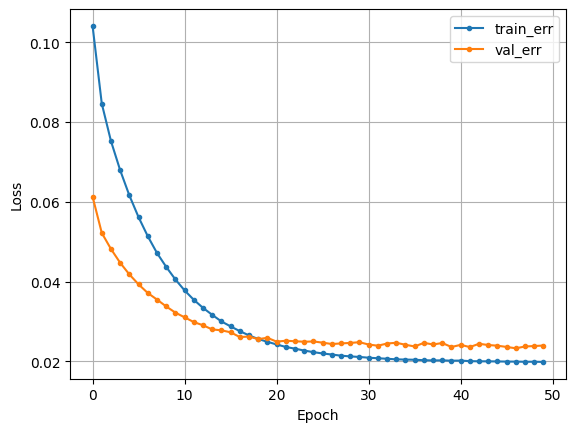

In [ ]:
model3_FC.compile(optimizer = 'adam', loss = 'mse')
hist = model3_FC.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model3_FC.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print("RMSE:", root_mean_squared_error(y_val2, pred))
print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
RMSE: 4383.821957215892
MAE :  3871.9744791666667
MAPE :  0.3767935087731437
R2 :  -0.6490985384302426


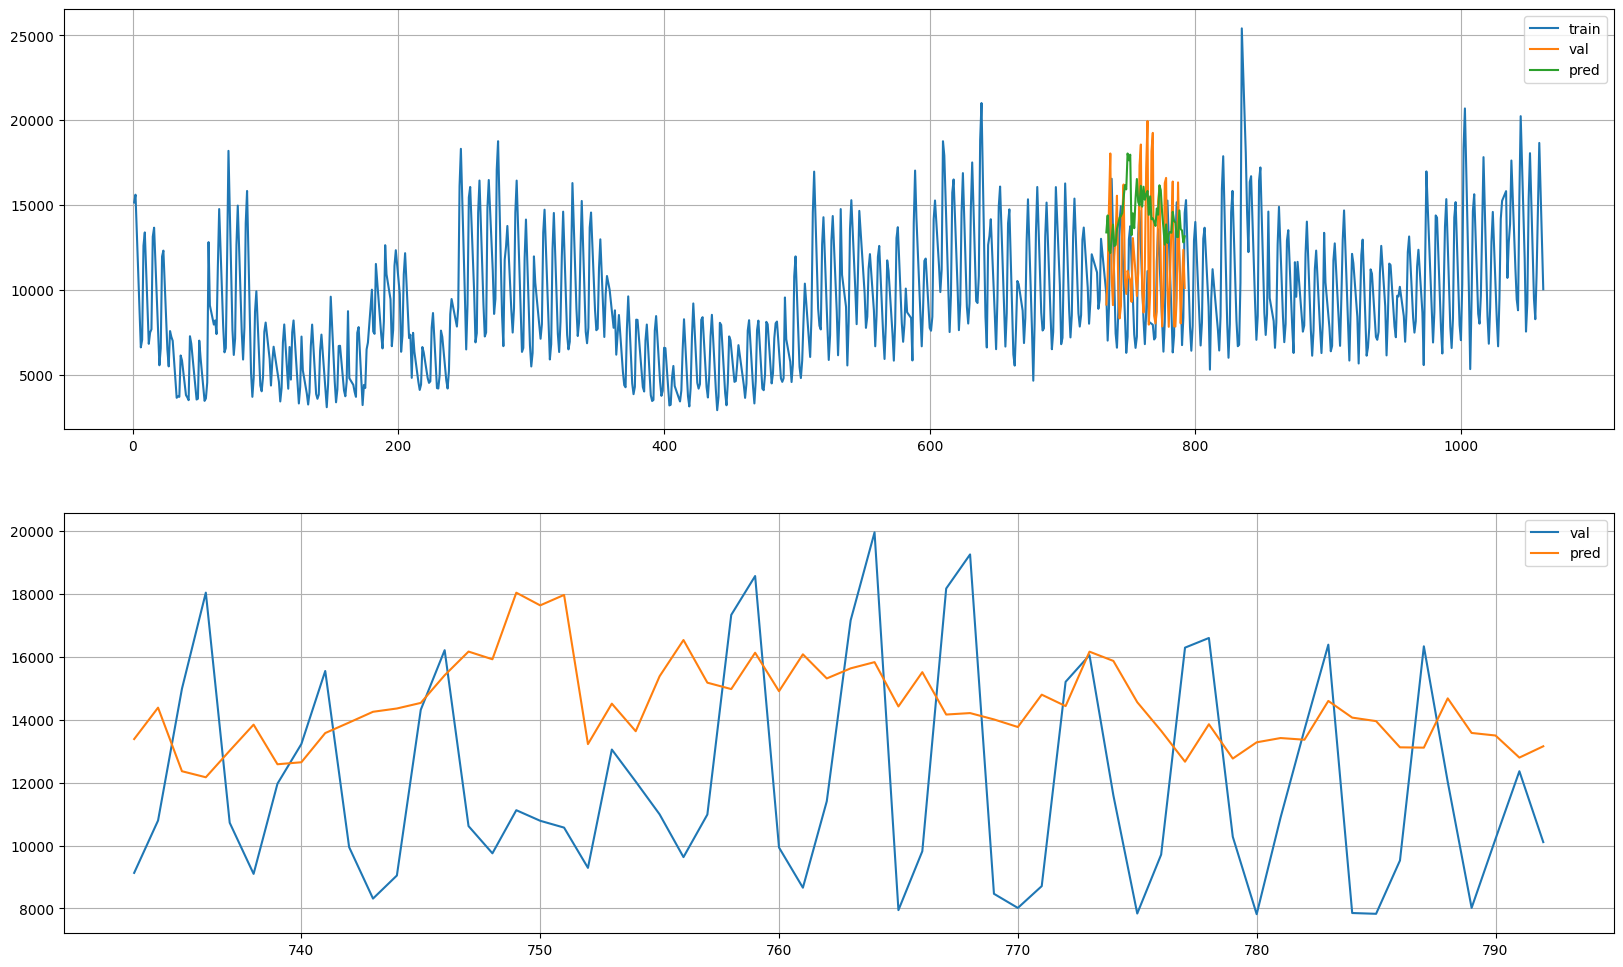

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

In [ ]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc(data_12, True)

### **2) 모델링**

In [ ]:
clear_session()

nfeat = x_train.shape[1]

model12_FC = Sequential([Dense(1, input_shape = (nfeat, ) )])
model12_FC.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │              32 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32 (128.00 B)

 Trainable params: 32 (128.00 B)

 Non-trainable params: 0 (0.00 B)

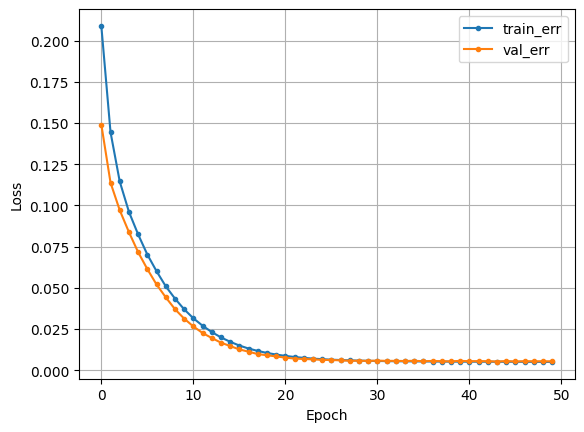

In [ ]:
model12_FC.compile(optimizer = 'adam', loss = 'mse')
hist = model12_FC.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model12_FC.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print("RMSE:", root_mean_squared_error(y_val2, pred))
print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
RMSE: 3567.026163195549
MAE :  2609.01923828125
MAPE :  1.2243089829580332e+18
R2 :  -0.03538663215559068


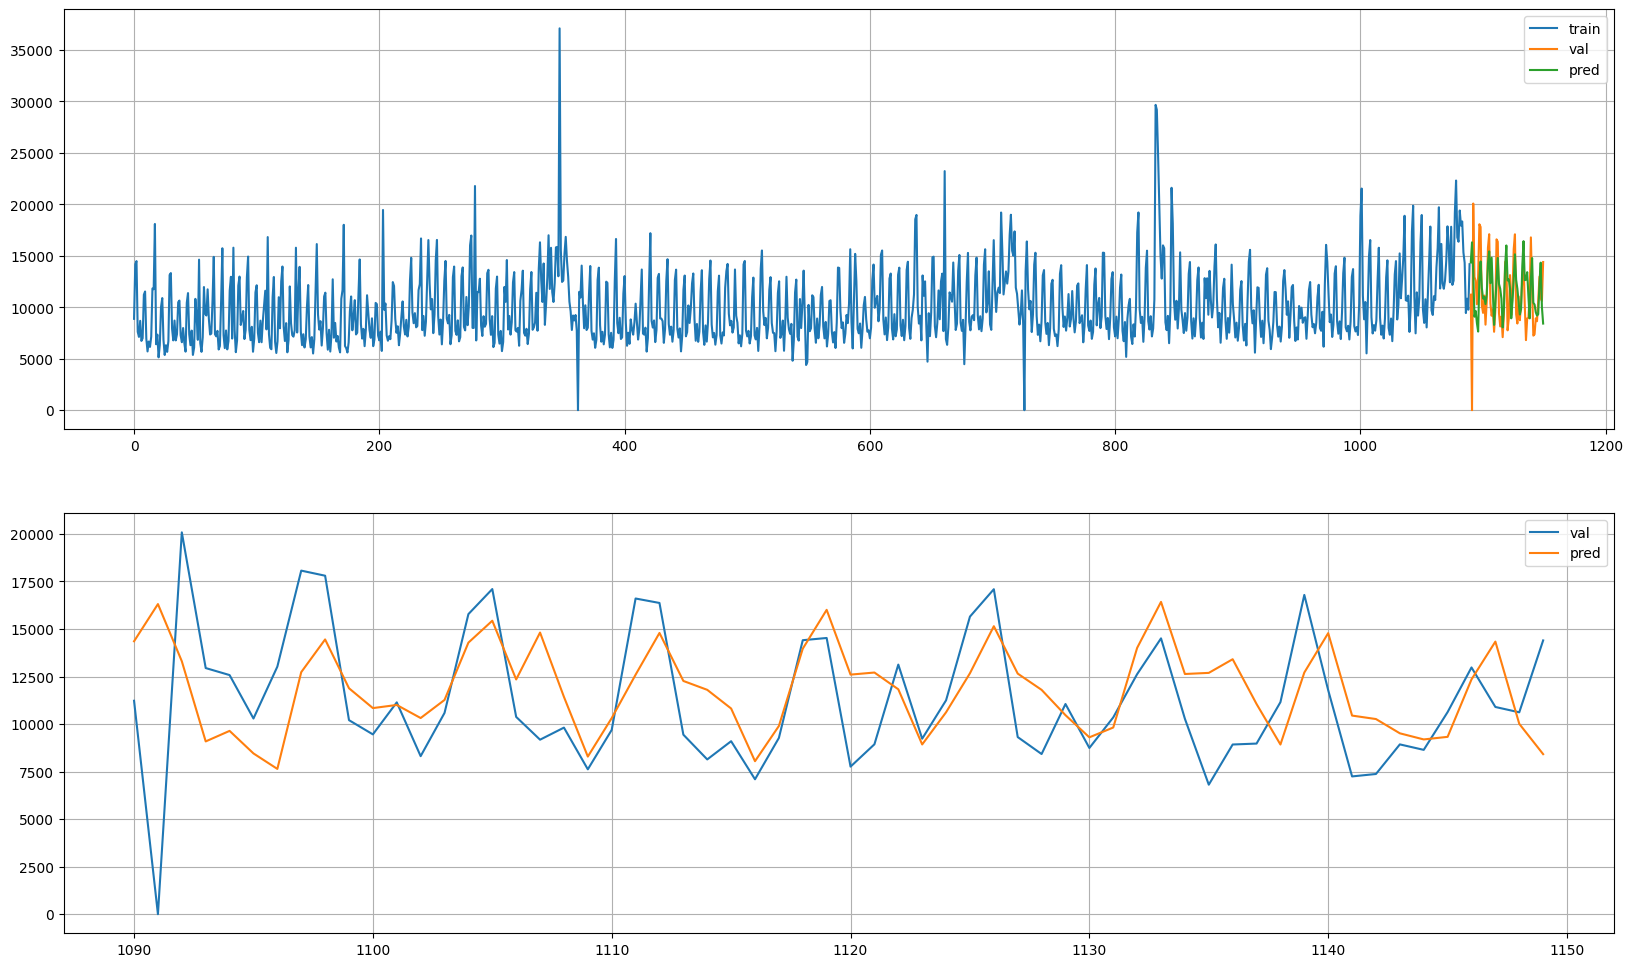

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

## **(3) 상품 : 42 - Agricultural products**

### **1) 데이터 준비**

In [ ]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc(data_42, target="Target_Qty", y_scale=True)

### **2) 모델링**

In [ ]:
clear_session()

nfeat = x_train.shape[1]

model42_FC = Sequential([Dense(1, input_shape = (nfeat, ) )])
model42_FC.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

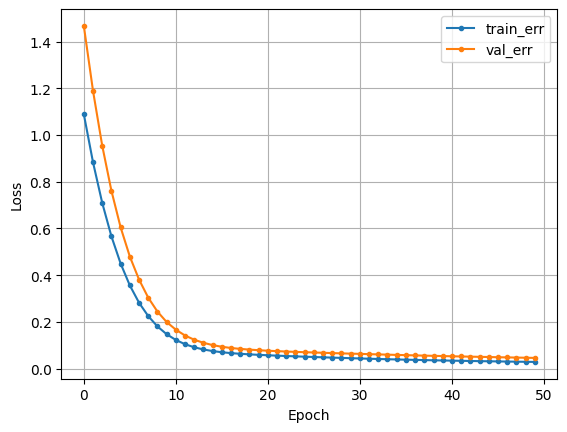

In [ ]:
model42_FC.compile(optimizer = 'adam', loss = 'mse')
hist = model42_FC.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model42_FC.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print("RMSE:", root_mean_squared_error(y_val2, pred))
print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
RMSE: 18.67649816926005
MAE :  14.745211664835612
MAPE :  0.1838493602370482
R2 :  -0.5165519563374714


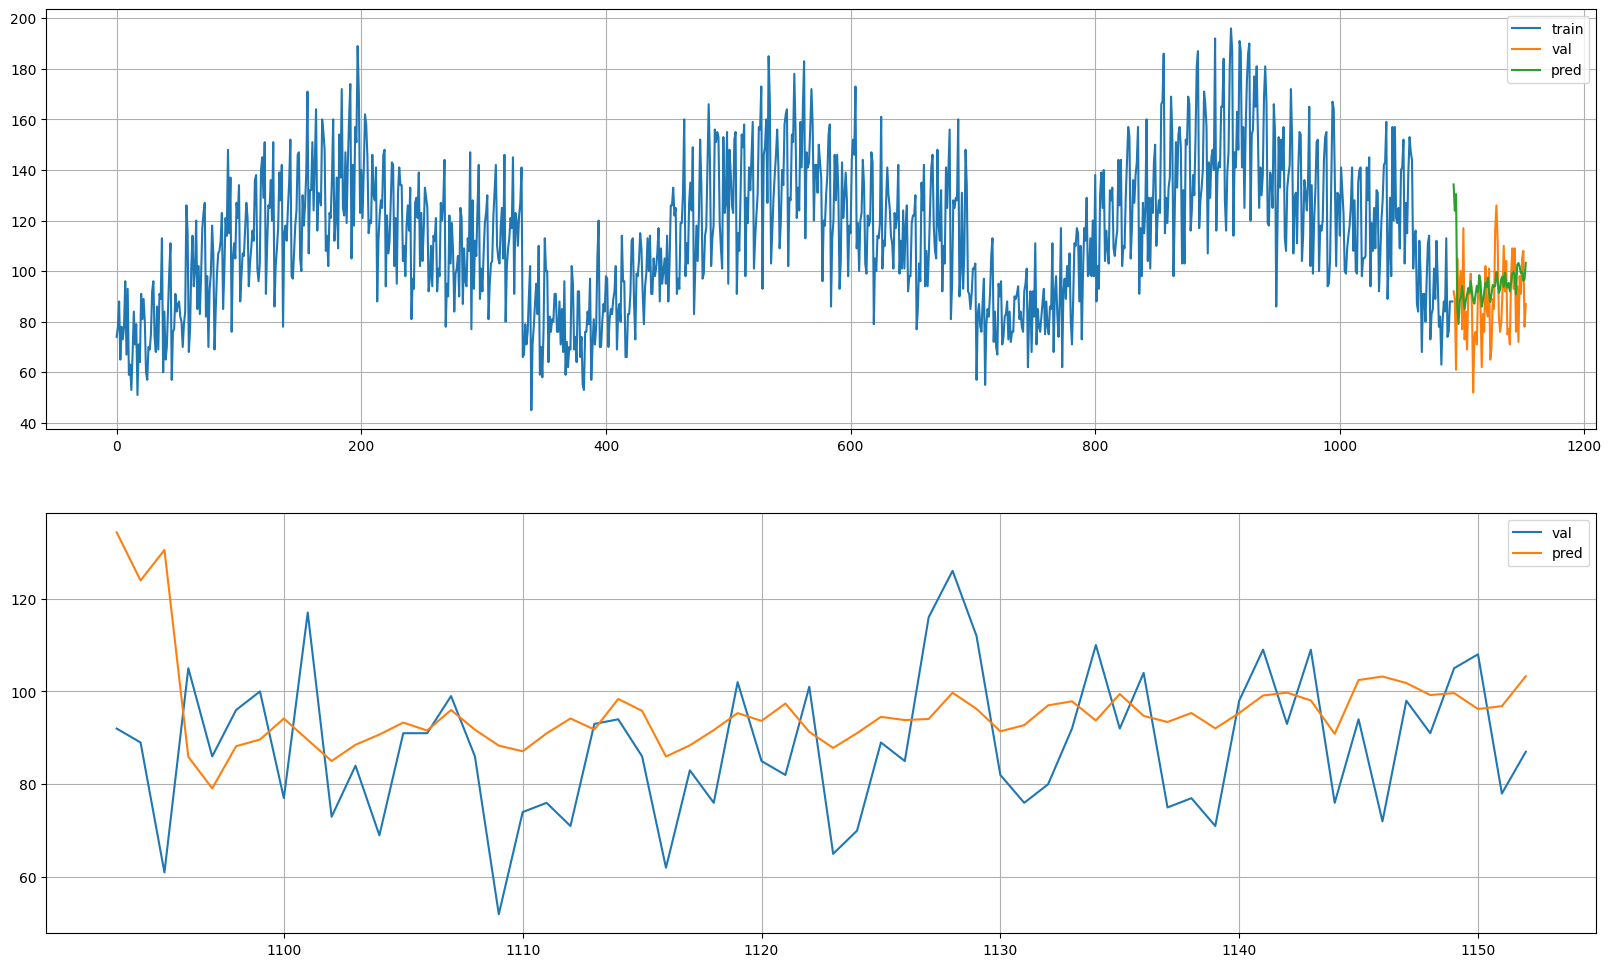

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [ ]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [ ]:
def preproc(data, target="12_shifted", y_scale = False):
    drop_columns = [target]
    if "Date" in data.columns:
      drop_columns.append("Date")

    data = data.dropna()
    x = data.drop(drop_columns, axis = 1)
    y = data.loc[:, target]

    # 가변수화
    try:
      x['Weekday'] = pd.Categorical(x['Weekday'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
      x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
      x = pd.get_dummies(x, columns = ['Weekday','Month'])
    except:
      pass

    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 60, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

In [ ]:
def preproc3d(data, timesteps, target="12_shifted", y_scale = False) :
    drop_columns = [target]
    if "Date" in data.columns:
      drop_columns.append("Date")

    data = data.dropna()
    x = data.drop(drop_columns, axis = 1)
    y = data.loc[:, target]

    # 가변수화
    try:
      x['Weekday'] = pd.Categorical(x['Weekday'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
      x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
      x = pd.get_dummies(x, columns = ['Weekday','Month'])
    except:
      pass

    col_names = list(x)


    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 120, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data_3, timesteps, target="y", y_scale=True)
y_min, y_max, x_train.shape, x_val.shape

(2902.0, 25413.0, (667, 7, 32), (120, 7, 32))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model3_LSTM = Sequential([LSTM(4, input_shape = (ts, nfeat) ),
                         Dense(1)])
model3_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4)                   │             592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 597 (2.33 KB)

 Trainable params: 597 (2.33 KB)

 Non-trainable params: 0 (0.00 B)

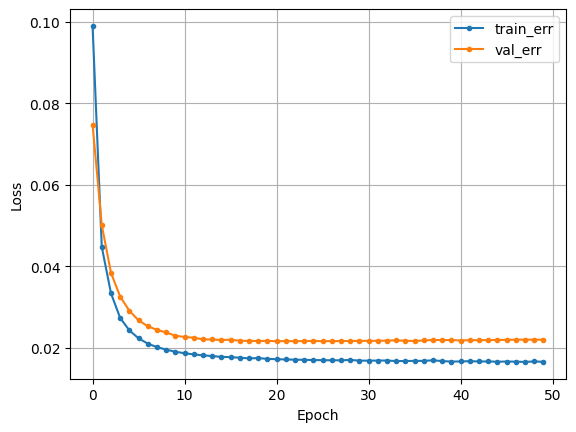

In [ ]:
model3_LSTM.compile(optimizer = 'adam', loss = 'mse')
hist = model3_LSTM.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model3_LSTM.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print("RMSE:", root_mean_squared_error(y_val2, pred))
print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
RMSE: 3732.9153540813863
MAE :  3183.4386393229165
MAPE :  0.28690287031058825
R2 :  -0.031719171474174024


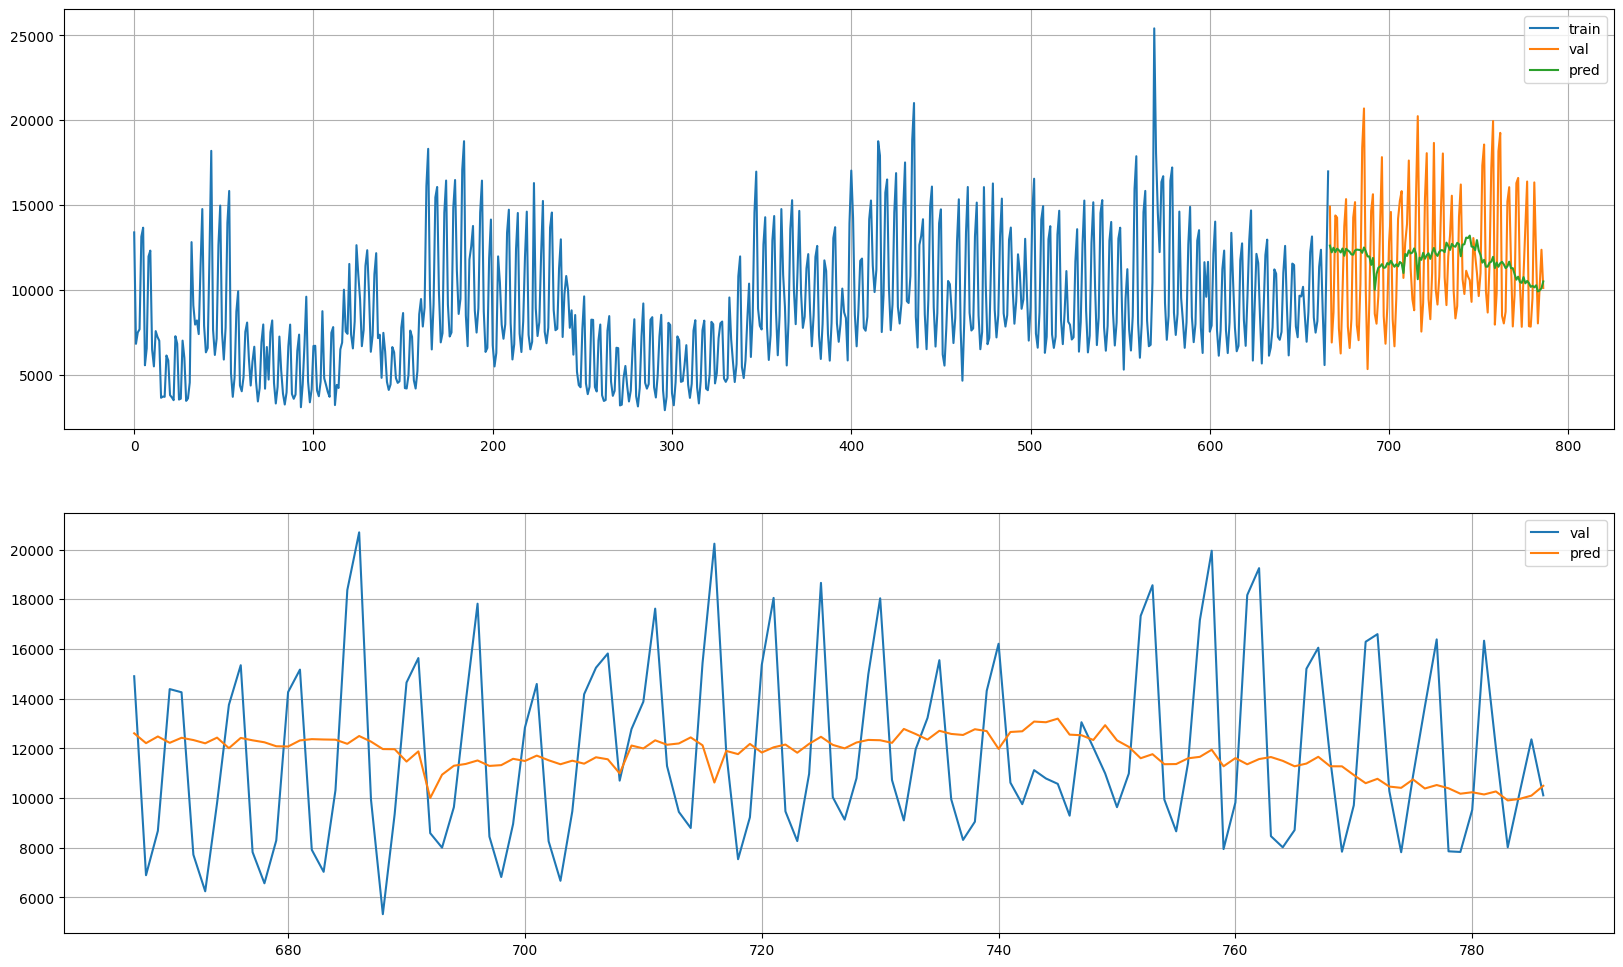

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data_12, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(0.0, 37106.0, (1024, 7, 31), (120, 7, 31))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model12_LSTM = Sequential([LSTM(4, input_shape = (ts, nfeat) ),
                         Dense(1)])
model12_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4)                   │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 581 (2.27 KB)

 Trainable params: 581 (2.27 KB)

 Non-trainable params: 0 (0.00 B)

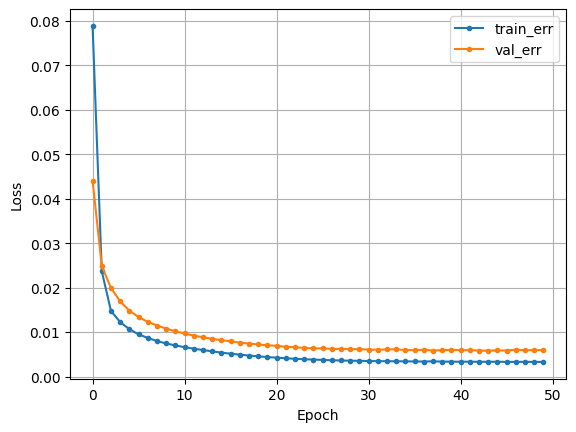

In [ ]:
model12_LSTM.compile(optimizer = 'adam', loss = 'mse')
hist = model12_LSTM.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model12_LSTM.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print("RMSE:", root_mean_squared_error(y_val2, pred))
print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
RMSE: 3255.72867717625
MAE :  2332.6362426757814
MAPE :  6.113154541558606e+17
R2 :  0.24981003270952373


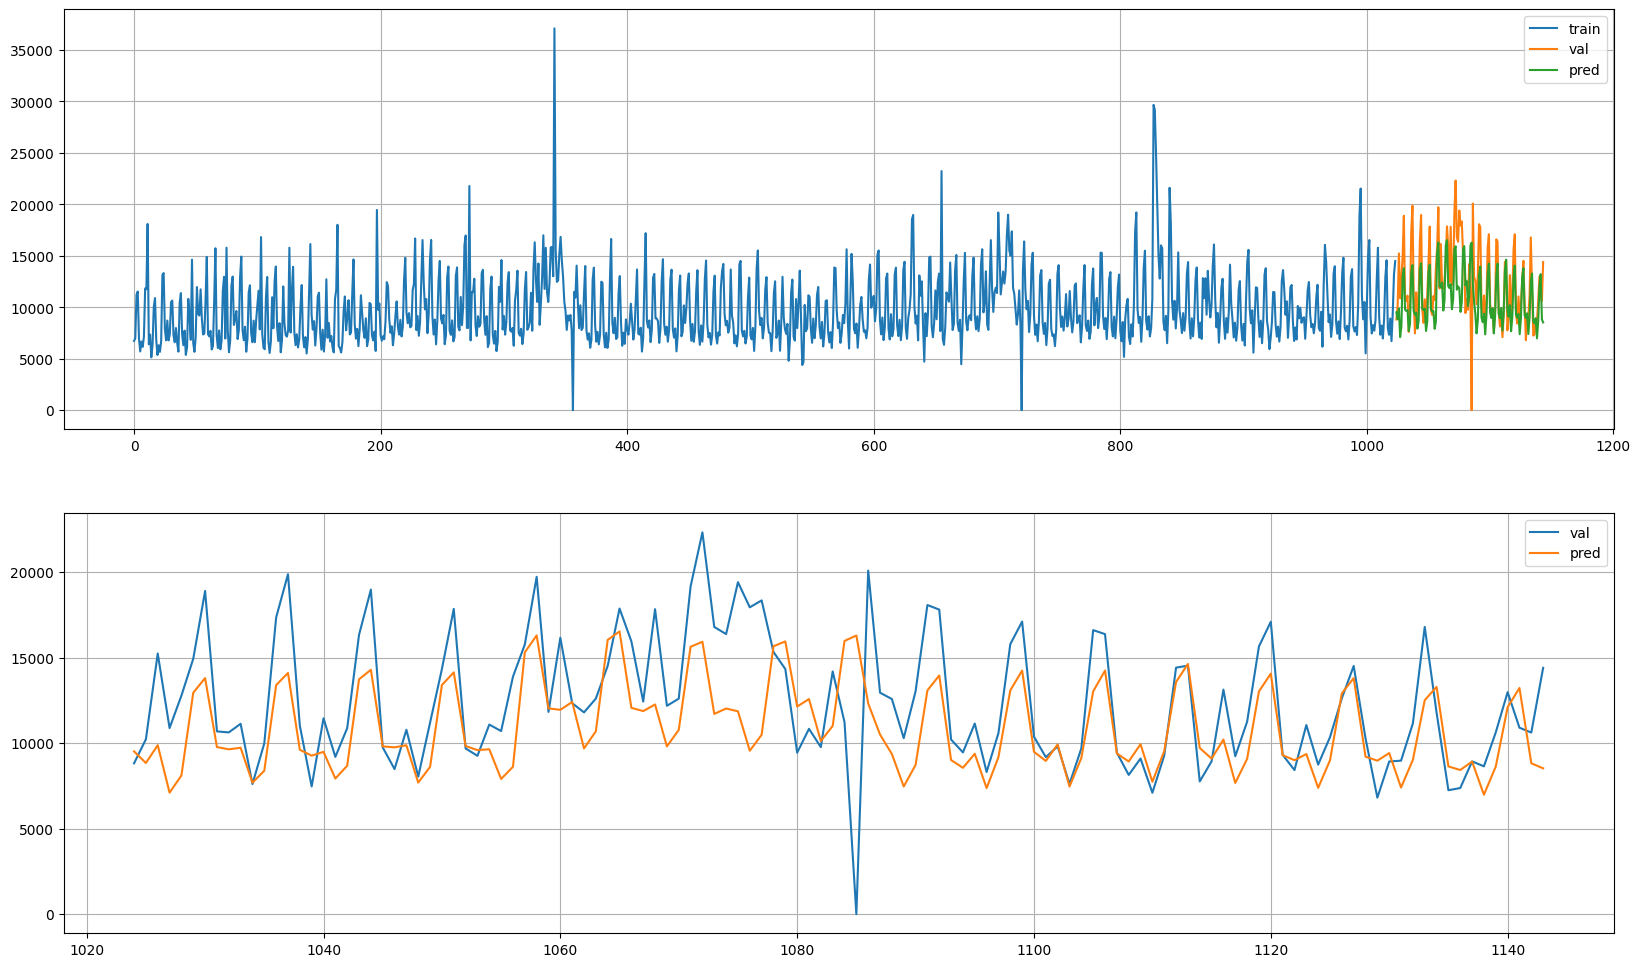

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data_42, timesteps, target="Target_Qty", y_scale=True)
y_min, y_max, x_train.shape, x_val.shape

(45.0, 196.0, (1027, 7, 11), (120, 7, 11))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model42_LSTM = Sequential([LSTM(4, input_shape = (ts, nfeat) ),
                         Dense(1)])
model42_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4)                   │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 261 (1.02 KB)

 Trainable params: 261 (1.02 KB)

 Non-trainable params: 0 (0.00 B)

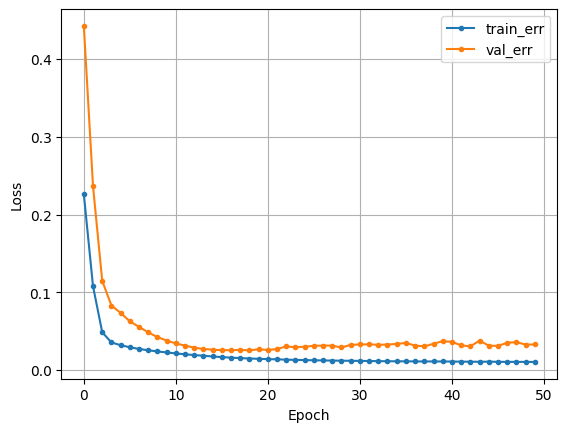

In [ ]:
model42_LSTM.compile(optimizer = 'adam', loss = 'mse')
hist = model42_LSTM.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model42_LSTM.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print("RMSE:", root_mean_squared_error(y_val2, pred))
print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
RMSE: 32.801292471437904
MAE :  28.704378000895183
MAPE :  0.3308530925339647
R2 :  -1.0123618738253026


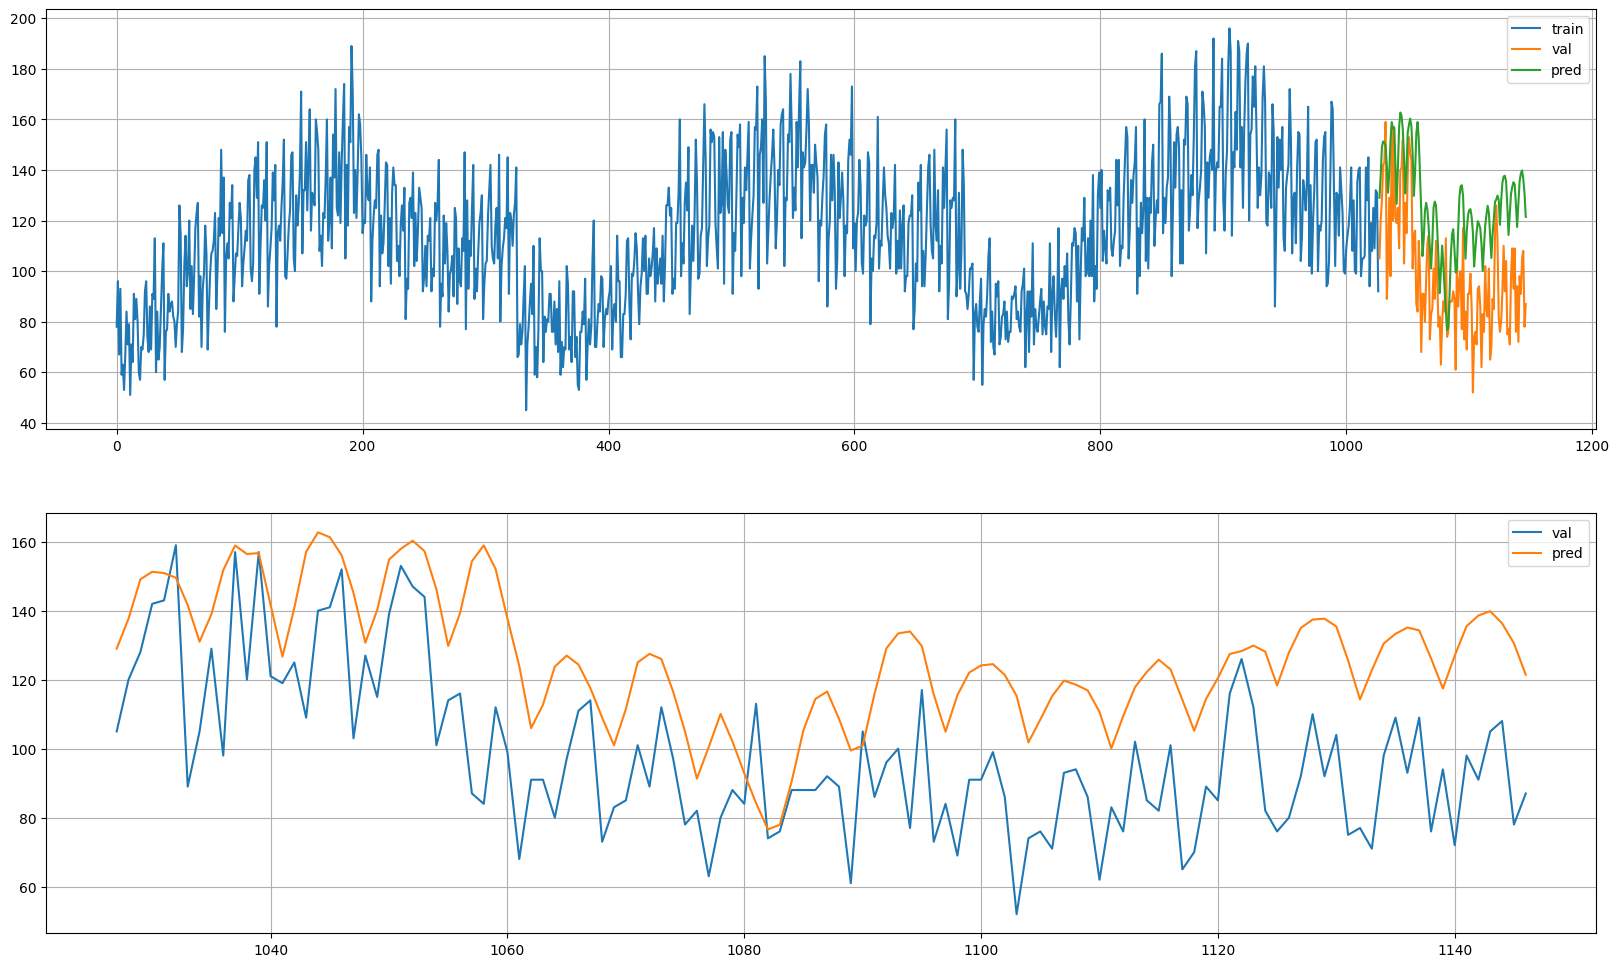

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)